In [55]:
import cv2
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from Thresholding import otsu
from Boundaries import boundaries_detection
from Boundaries import freeman_chain_code
from Borders import border_detection
from Boundaries import fourier_descriptors
from Boundaries import extreme_points
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
class Image:
    def __init__(self,data,label,rotated=False,resized=False):
        self.data = data
        self.borderImage = None
        self.label = label
        self.boundary = None
        self.boundaryImage = None
        self.extremePoints = None
        self.rotated = rotated
        self.resized = resized

    def __str__(self) -> str:
        return f"{self.data}"

    def getBoundaries(self)->None:
        binaryImage = otsu.otsu_image(self.data)
        self.borderImage = border_detection.canny_bordering(binaryImage)
        self.boundaryImage,self.boundary = boundaries_detection.moore_boundary_detection(self.borderImage)

    def getFreemanChain(self):
        if(self.boundary is None):
            self.getBoundaries()
        freemanChainCode = freeman_chain_code.calculate_chain_code(self.boundaryImage)
        if(freemanChainCode == []):
            self.freemanChainCode = []
        self.freemanChainCode = freeman_chain_code.normalize_chain(freemanChainCode)

    def getArea(self):
        rows,columns = self.data.shape
        area = 0
        for r in range(rows):
            for c in range(columns):
                if(self.data[r][c] == 255):
                    area += 1
        self.area = area

    def getPerimeter(self):
        if(self.freemanChainCode is None):
            self.getFreemanChain()
        perimeter = 0
        for value in self.freemanChainCode:
            if(value%2 == 0):
                perimeter += 1
            else:
                perimeter += math.sqrt(2)
        self.perimeter = perimeter
        
    def getCompactness(self):
        if(self.perimeter is None):
            self.getPerimeter()
        if(self.area is None):
            self.getArea()
        self.compactness = self.perimeter**2 / self.area

    def getRectangularity(self):
        rows,columns = self.data.shape
        points = [math.inf,-1,math.inf,-1] # heighleast,heighmost,leftmost,rightmost
        for r in range(rows):
            for c in range(columns):
                if(self.data[r][c] == 255):
                    if(r < points[0]):
                        points[0] = r
                    if(r > points[1]):
                        points[1] = r
                    if(c < points[2]):
                        points[2] = c
                    if(c > points[3]):
                        points[3] = c
        areaR = (points[1]-points[0]) * (points[3]-points[2])
        self.rectangularity = self.area/areaR

    def getFourierDescriptors(self):
        if self.boundary is None:
            self.getBoundaries()
        self.fourierDescriptors = fourier_descriptors.fourier_descriptors(self.boundary.copy())

    def getExtremePoints(self):
        if self.boundary is None:
            self.getBoundaries()
        self.extremePoints = extreme_points.findExtremePoints(self.boundary)
        
    def plotExtremePoints(self):
        if self.extremePoints is None:
            self.getExtremePoints()
        plt.figure()
        plt.imshow(self.data, cmap="gray")
        for point in self.extremePoints:
            y, x = point
            plt.scatter(x, y, c="red")
        plt.show()

    def plotImage(self):
        plt.figure()
        plt.subplot(131)
        plt.imshow(self.data,cmap="gray")
        plt.subplot(132)
        plt.imshow(self.borderImage,cmap="gray")
        plt.subplot(133)
        plt.imshow(self.boundaryImage,cmap="gray")
        plt.show()


## Load data

In [56]:
images = []
imagesRotated = []
imagesResized = []
folder_path = 'images'
init_folders = os.listdir(folder_path)
for folder in init_folders:
    init_folder_path = os.path.join(folder_path, folder)
    cont = 0
    for image_path in os.listdir(init_folder_path):
        if(cont == 100):
            break
        image_folder = os.path.join(init_folder_path,image_path)
        image = cv2.imread(image_folder,cv2.IMREAD_GRAYSCALE)
        imageR = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        imagesRZD = cv2.resize(image,(37,37),interpolation=cv2.INTER_NEAREST)
        images.append(Image(image,folder))
        imagesRotated.append(Image(imageR,folder,rotated=True))
        imagesResized.append(Image(imagesRZD,folder,resized=True))
        cont += 1

## Train model


In [57]:
listImages = images + imagesRotated + imagesResized 
b_feature = np.zeros((len(listImages), 14))
labels = [int(img.label) for img in listImages] 

In [58]:
for i in range(len(listImages)):
    listImages[i].getFreemanChain()
    if(listImages[i].freemanChainCode == []):
        continue
    listImages[i].getArea()
    listImages[i].getPerimeter()
    listImages[i].getCompactness()
    listImages[i].getRectangularity()
    listImages[i].getFourierDescriptors()
    listImages[i].getExtremePoints()
    b_feature[i][0] = listImages[i].area
    b_feature[i][1] = listImages[i].perimeter
    b_feature[i][2] = listImages[i].compactness
    b_feature[i][3] = listImages[i].rectangularity
    eP = listImages[i].extremePoints
    b_feature[i][4] = eP[0][0]
    b_feature[i][5] = eP[0][0]
    b_feature[i][6] = eP[1][0]
    b_feature[i][7] = eP[1][1]
    b_feature[i][8] = eP[2][0]
    b_feature[i][9] = eP[2][1]
    b_feature[i][10] = eP[3][0]
    b_feature[i][11] = eP[3][1]
    b_feature[i][12] = np.mean(np.abs(listImages[i].fourierDescriptors))
    b_feature[i][12] = np.var(np.abs(listImages[i].fourierDescriptors))

In [68]:
X_train, X_test, y_train, y_test = train_test_split(b_feature, labels, test_size=.50, random_state=42)
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.256
[[1.50000000e+02 1.28651804e+02 1.10341910e+02 ... 7.00000000e+00
  3.29907605e+01 2.19436097e+04]
 [1.23000000e+02 1.84320851e+02 2.76212814e+02 ... 7.00000000e+00
  3.98895038e+01 2.87328275e+04]
 [7.80000000e+01 1.58521861e+02 3.22168981e+02 ... 3.00000000e+00
  3.67651158e+01 2.46683263e+04]
 ...
 [6.00000000e+01 1.08438600e+02 1.95982167e+02 ... 5.00000000e+00
  3.15594842e+01 1.76449990e+04]
 [1.58000000e+02 1.18769553e+02 8.92797888e+01 ... 4.00000000e+00
  3.53104387e+01 2.26861729e+04]
 [9.10000000e+01 1.92320851e+02 4.06453954e+02 ... 8.00000000e+00
  3.99529654e+01 3.04057606e+04]]


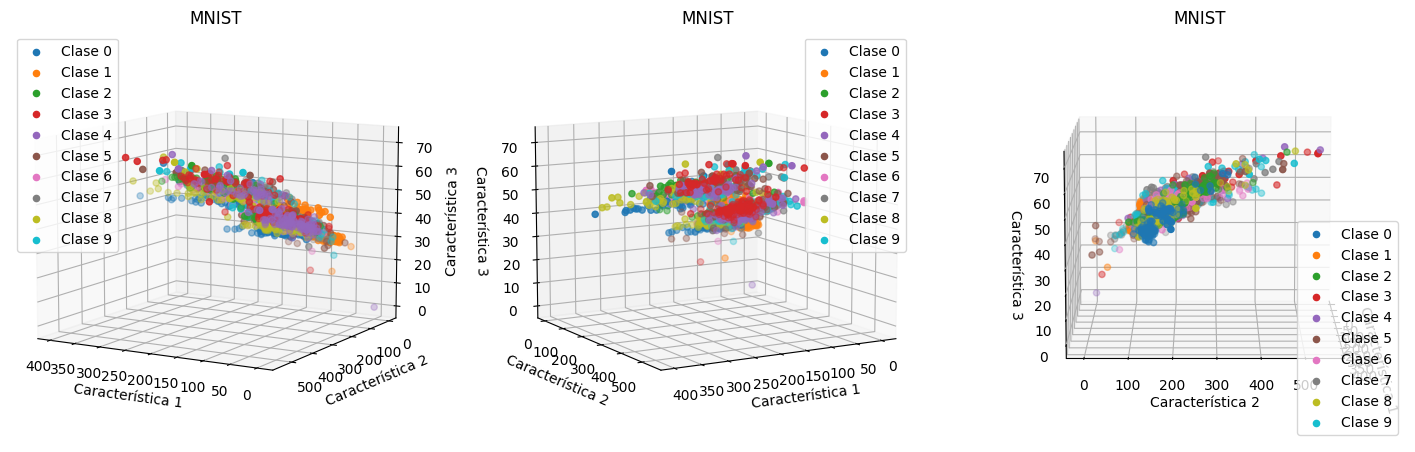

In [100]:
# Crear una lista de colores para las 10 clases
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Crear la figura y el espacio 3D
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(131, projection='3d')

# Ploteo de los puntos en 3D con colores correspondientes a las clases
for i in range(10):
    a = [_ for _ in range(len(X_test)) if y_test[_] == i]
    class_points = X_test[a]
    ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color=colors[i], label=f'Clase {i}')
# Configuración del gráfico
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.legend()
plt.title('MNIST')
ax.view_init(elev=10, azim=120)
ax = fig.add_subplot(132, projection='3d')

# Ploteo de los puntos en 3D con colores correspondientes a las clases
for i in range(10):
    a = [_ for _ in range(len(X_test)) if y_test[_] == i]
    class_points = X_test[a]
    ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color=colors[i], label=f'Clase {i}')
# Configuración del gráfico
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.legend()
plt.title('MNIST')
ax.view_init(elev=10, azim=60)
ax = fig.add_subplot(133, projection='3d')
# Ploteo de los puntos en 3D con colores correspondientes a las clases
for i in range(10):
    a = [_ for _ in range(len(X_test)) if y_test[_] == i]
    class_points = X_test[a]
    ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color=colors[i], label=f'Clase {i}')
# Configuración del gráfico
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.legend()
plt.title('MNIST')
ax.view_init(elev=10, azim=0)
# Mostrar el gráfico
plt.show()

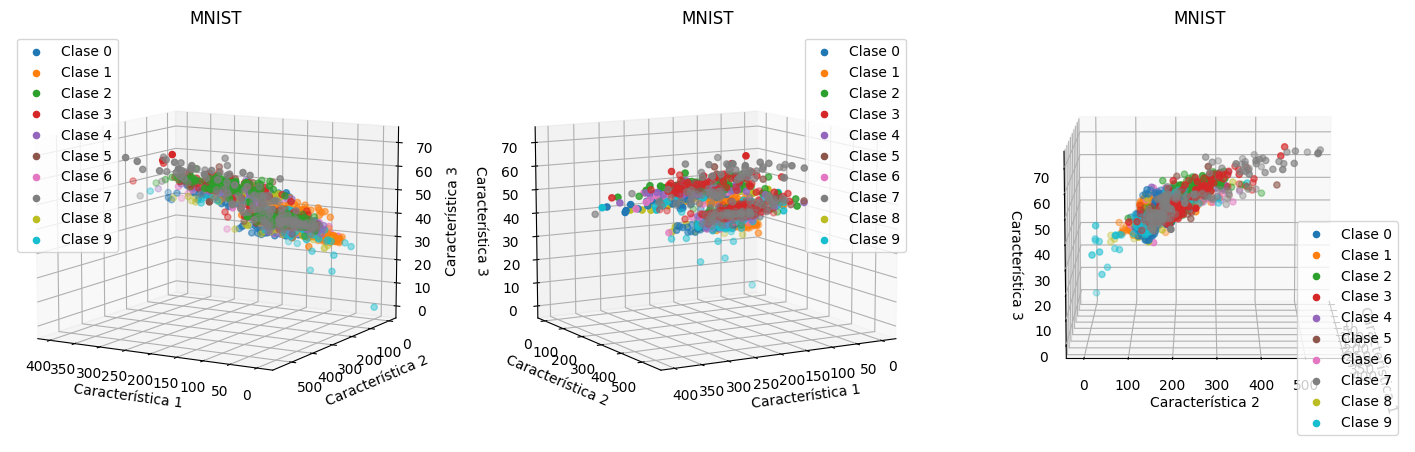

In [102]:
# Crear una lista de colores para las 10 clases
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Crear la figura y el espacio 3D
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(131, projection='3d')

# Ploteo de los puntos en 3D con colores correspondientes a las clases
for i in range(10):
    a = [_ for _ in range(len(X_test)) if predictions[_] == i]
    class_points = X_test[a]
    ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color=colors[i], label=f'Clase {i}')
# Configuración del gráfico
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.legend()
plt.title('MNIST')
ax.view_init(elev=10, azim=120)
ax = fig.add_subplot(132, projection='3d')

# Ploteo de los puntos en 3D con colores correspondientes a las clases
for i in range(10):
    a = [_ for _ in range(len(X_test)) if predictions[_] == i]
    class_points = X_test[a]
    ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color=colors[i], label=f'Clase {i}')
# Configuración del gráfico
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.legend()
plt.title('MNIST')
ax.view_init(elev=10, azim=60)
ax = fig.add_subplot(133, projection='3d')
# Ploteo de los puntos en 3D con colores correspondientes a las clases
for i in range(10):
    a = [_ for _ in range(len(X_test)) if predictions[_] == i]
    class_points = X_test[a]
    ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color=colors[i], label=f'Clase {i}')
# Configuración del gráfico
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.legend()
plt.title('MNIST')
ax.view_init(elev=10, azim=0)
# Mostrar el gráfico
plt.show()

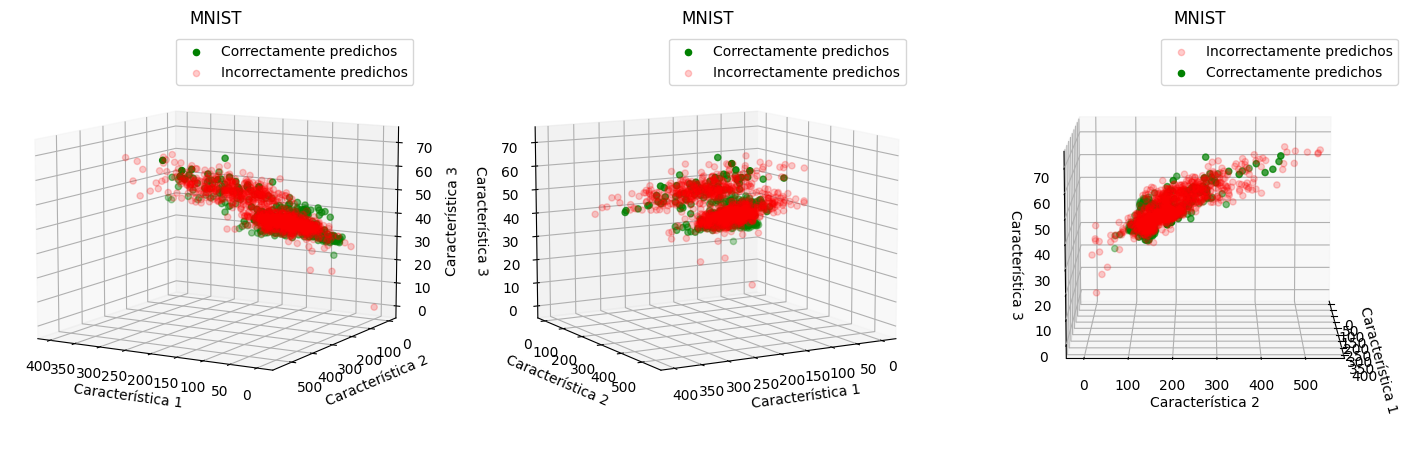

In [105]:
# Crear la figura y el espacio 3D
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(131, projection='3d')
resultados = ["Correctamente predichos","Incorrectamente predichos"]
a = [_ for _ in range(len(X_test)) if y_test[_] == predictions[_]]
class_points = X_test[a]
ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color='g', label=resultados[0])
a = [_ for _ in range(len(X_test)) if y_test[_] != predictions[_]]
class_points = X_test[a]
ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color='r', label=resultados[1],alpha=0.2)
# Configuración del gráfico
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.legend()
plt.title('MNIST')
ax.view_init(elev=10, azim=120)
ax = fig.add_subplot(132, projection='3d')
a = [_ for _ in range(len(X_test)) if y_test[_] == predictions[_]]
class_points = X_test[a]
ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color='g', label=resultados[0])
a = [_ for _ in range(len(X_test)) if y_test[_] != predictions[_]]
class_points = X_test[a]
ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color='r', label=resultados[1],alpha=0.2)
# Configuración del gráfico
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.legend()
plt.title('MNIST')
ax.view_init(elev=10, azim=60)
ax = fig.add_subplot(133, projection='3d')
a = [_ for _ in range(len(X_test)) if y_test[_] != predictions[_]]
class_points = X_test[a]
ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color='r', label=resultados[1],alpha=0.2)
a = [_ for _ in range(len(X_test)) if y_test[_] == predictions[_]]
class_points = X_test[a]
ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 12], color='g', label=resultados[0])

# Configuración del gráfico
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.legend()
plt.title('MNIST')
ax.view_init(elev=10, azim=0)
# Mostrar el gráfico
plt.show()